In [1]:
%matplotlib inline
from __future__ import print_function
import os
import sys
sys.path.append("..")
import shutil
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle as rect
import matplotlib.pyplot as plt
import flopy
import pyemu

## Monte Carlo with Freyberg Model

Adapted from the examples provided with `pyemu`.  This is essentially the same work flow as ``freyberg_kr`` and ``freyberg_zone`` monte carlo notebooks - again, the power of scripting!


## Using `pyemu`

In [12]:
import freyberg_setup as fs
fs.setup_pest_pp()
working_dir = fs.WORKING_DIR_PP
pst_name = fs.PST_NAME_PP


['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'kzone.ref', 'mpath.in', 'potobs_group.csv', 'Process_output.py', 'really_noisy_heads.txt', 'run_true_model.py', 'strt.ref', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_pp
FloPy is using the following executable to run the model: /Users/jwhite/Dev/GW1876/activities/freyberg_pilot_points_monte_carlo/freyberg_pp/mfnwt

                                  MODFLOW-NWT-SWR1

/Users/jwhite/Dev/python/pyemu/pyemu/pst/pst_utils.py:419: UserWarning: pst_from_io_files has moved to pyemu.helpers and is also now avaiable as a Pst class method (Pst.from_io_files())
  "now avaiable as a Pst class method (Pst.from_io_files())")


run():./inschek freyberg.travel.ins freyberg.travel
run():./inschek vol.dat.ins vol.dat
starting interp point loop for 800 points
took 2.593129 seconds
run():./pestchek freyberg_pp.pst
run():./pestpp freyberg_pp.init.pst


In [13]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))

In [14]:
mc = pyemu.MonteCarlo(pst=pst,verbose=False)

Important: since we didn't pass a ``parcov`` arg to ``MonteCarlo``, that means the prior parameter covariance matrix was constructed from the parameter bounds (it does not include spatial correlation information for the pilot points - remember all the geostatics?)

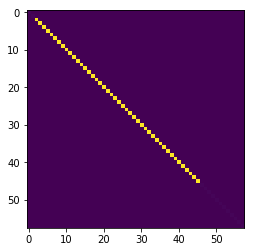

In [15]:
plt.imshow(mc.parcov.as_2d)

## Drawing from the prior
Each ``MonteCarlo`` instance has a ``parensemble`` attribute which itself is an instance of ``Ensemble`` class, which is derived from ``pandas.DataFrame``.  What all that means is that the parameter ensembles behave just like ```DataFrame```s

### ```draw```
The ``draw`` method is the main entry point into getting realizations. It accepts several optional arguments.  Without any args, it makes a single draw from the prior, which uses a $\boldsymbol{\mu}$ (mean) vector of the parameter values listed in the pest control file:


In [16]:
mc.draw()
print(mc.parensemble.shape)

(1, 58)


``draw`` also accepts a ``num_reals`` argument to specify the number of draws to make:

In [17]:
mc.draw(num_reals=1000)
print(mc.parensemble.shape)
print(mc.parensemble.mean().head())

(1000, 58)
parnme
rch_0     1.005465
rch_1     1.007919
hk00      9.860765
hk01     10.067818
hk02      9.795943
dtype: float64


## plotting

Since ```ParameterEnsemble``` is dervied from ```pandas.DataFrame```, it has all the cool methods and attributes we all love.  Let's compare the results of drawing from a uniform vs a gaussian distribution.  This may take some time.

In [18]:
mc.parensemble.columns

Index(['rch_0', 'rch_1', 'hk00', 'hk01', 'hk02', 'hk03', 'hk04', 'hk05',
       'hk06', 'hk07', 'hk08', 'hk09', 'hk10', 'hk11', 'hk12', 'hk13', 'hk14',
       'hk15', 'hk16', 'hk17', 'hk18', 'hk19', 'hk20', 'hk21', 'hk22', 'hk23',
       'hk24', 'hk25', 'hk26', 'hk27', 'hk28', 'hk29', 'hk30', 'hk31', 'hk32',
       'hk33', 'hk34', 'hk35', 'hk36', 'hk37', 'hk38', 'hk39', 'hk40', 'hk41',
       'hk42', 'hk43', 'w0_r09_c16', 'w0_r11_c13', 'w0_r20_c14', 'w0_r26_c10',
       'w0_r29_c06', 'w0_r34_c12', 'w1_r09_c16', 'w1_r11_c13', 'w1_r20_c14',
       'w1_r26_c10', 'w1_r29_c06', 'w1_r34_c12'],
      dtype='object', name='parnme')

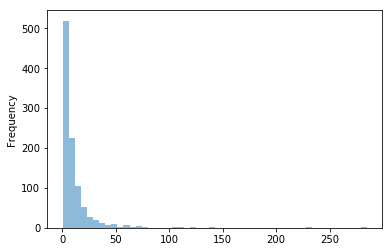

In [19]:
ax = plt.subplot(111)
partoplot = 'hk10'
mc.parensemble.loc[:,partoplot].plot(kind="hist",bins=50,ax=ax,alpha=0.5)

In [30]:
def plot_first_10_reals(paren):
    arrs = []
    pp_df = pyemu.gw_utils.pp_tpl_to_dataframe(os.path.join(working_dir,"hkpp.dat.tpl"))
    pp_df.loc[:,"iidx"] = pp_df.index
    for real in paren.index.values[:10]:
        pp_df.index = pp_df.parnme
        pp_df.loc[:,"parval1"] = paren.loc[real,pp_df.parnme].T
        pp_df.index = pp_df.iidx
        arr = pyemu.utils.gw_utils.fac2real(pp_df,os.path.join(working_dir,"hkpp.dat.fac"))
        arrs.append(np.log10(np.loadtxt(arr)))
    mx,mn = -1.0E+10,1.0e+10
    for arr in arrs:
        mx = max(mx,arr.max())
        mn = min(mn,arr.min())
    fig = plt.figure(figsize=(10,10))
    m = flopy.modflow.Modflow.load(fs.MODEL_NAM,model_ws=working_dir)
    for i,arr in enumerate(arrs):
        ax = plt.subplot(2,5,i+1,aspect="equal")
        m.upw.hk[0] = arr
        m.upw.hk[0].plot(axes=[ax],alpha=0.5)
        ax.scatter(pp_df.x,pp_df.y,marker='.',color='k',s=4)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    plt.show()
    
    

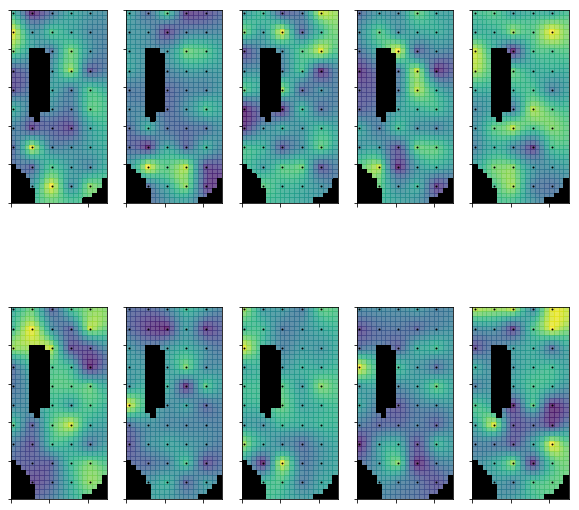

In [31]:
plot_first_10_reals(mc.parensemble)

Do these look "right" (from a geologic stand point)? Lots of "random" variation (pilot points spatially near each other can have very different values)...not much structure...why?

Let's use a full covariance matrix and see how that looks

,rch_0,rch_1,hk00,hk01,hk02,hk03,hk04,hk05,hk06,hk07,...,w0_r20_c14,w0_r26_c10,w0_r29_c06,w0_r34_c12,w1_r09_c16,w1_r11_c13,w1_r20_c14,w1_r26_c10,w1_r29_c06,w1_r34_c12
rch_0,0.003076,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rch_1,0.000000,0.003076,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hk00,0.000000,0.000000,0.250000,0.237807,0.226209,0.215177,0.204683,0.237807,0.232933,0.223555,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hk01,0.000000,0.000000,0.237807,0.250000,0.237807,0.226209,0.215177,0.232933,0.237807,0.232933,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hk02,0.000000,0.000000,0.226209,0.237807,0.250000,0.237807,0.226209,0.223555,0.232933,0.237807,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


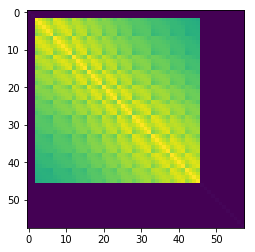

In [32]:
v = pyemu.geostats.ExpVario(contribution=1.0,a=20000,anisotropy=1.0,bearing=0.0)
gs = pyemu.utils.geostats.GeoStruct(variograms=[v])
pp_tpl = os.path.join(working_dir,"hkpp.dat.tpl")
cov = pyemu.helpers.geostatistical_prior_builder(pst=mc.pst,struct_dict={gs:pp_tpl})
plt.imshow(cov.x,interpolation="nearest")
cov.to_dataframe().head()

In [33]:
mc_full = pyemu.MonteCarlo(pst=pst,parcov=cov)

In [34]:
mc_full.draw(1000)

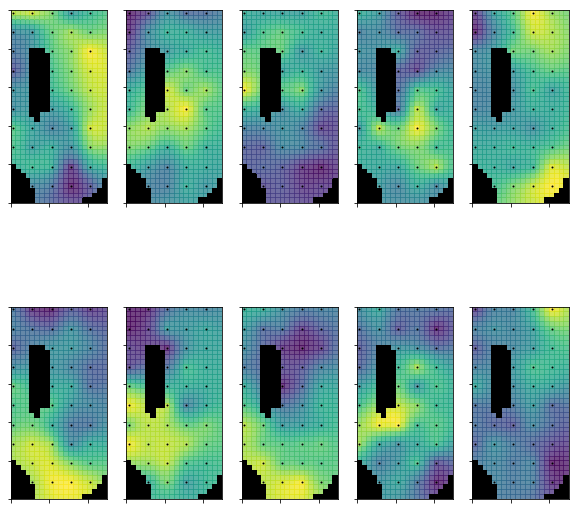

In [35]:
plot_first_10_reals(mc_full.parensemble)

Much better! now let's run the parameter ensemble through the model using sweep

In [36]:
mc_full.parensemble.to_csv(os.path.join(working_dir,"sweep_in.csv"))

Remember, this is going to give your machine a work out....watch what is going on the terminal and wait for the "*" to become a number

In [37]:
os.chdir(working_dir)
pyemu.helpers.start_slaves('.',"sweep",pst_name,num_slaves=10,
                           master_dir='.')
os.chdir("..")

master:sweep freyberg_pp.pst /h :4004 in .
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_0
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_1
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_2
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_3
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_4
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_5
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_6
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_7
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_8
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_9


In [39]:
df_out = pd.read_csv(os.path.join(working_dir,"sweep_out.csv"),index_col=0)
df_out.columns = [c.lower() for c in df_out.columns]

In [40]:

df_out = df_out.loc[df_out.failed_flag==0,:] #drop an failed runs
df_out.head()

,input_run_id,failed_flag,phi,meas_phi,regul_phi,vol_storage,head,vol_constan,vol_in-out,forehead,...,vol_total_19750101,vol_wells_19750101,vol_constan_19750102,vol_in-out_19750102,vol_percent_19750102,vol_recharg_19750102,vol_river_l_19750102,vol_storage_19750102,vol_total_19750102,vol_wells_19750102
run_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,121187.737829,121182.377789,5.360040,0,0,0,0,0,...,44.0,-4364672.50,-465897.531250,44.0,0.00,7036272.5,-2860799.250,657288.812500,44.0,-4366820.50
1,1,0,1773.941803,1772.091980,1.849823,0,0,0,0,0,...,863.0,-4389459.00,-39873.859375,864.0,0.01,7526588.5,-3127979.000,34084.886719,864.0,-4391957.50
2,2,0,1040.593133,1039.403026,1.190107,0,0,0,0,0,...,956.0,-4029262.25,-235362.796875,956.0,0.01,6905296.0,-2705134.500,67674.609375,956.0,-4031517.00
3,3,0,2451.536761,2448.910709,2.626052,0,0,0,0,0,...,1210.5,-4150498.25,274275.750000,1210.0,0.02,5666533.5,-1832816.875,45985.113281,1210.0,-4152767.25
4,4,0,6490.354331,6486.534755,3.819576,0,0,0,0,0,...,1354.0,-4376577.00,813391.500000,1354.0,0.01,6575852.0,-3044309.000,35161.125000,1354.0,-4378741.50


So now we need to specify our "good enough" threshold.  Look back at your ``freyberg_pilot_points_2\freyberg_pilot_points_setup`` notebook and use a value slightly larger than your ``phimlim`` value...makes sense right?  We should expect "good enough" realizations to atleast be in the ball park of the target objective function....

In [41]:
acceptable_phi = 500.0
good_enough = df_out.loc[df_out.phi<acceptable_phi].index.values
print(good_enough)

[]


Oh crap! what happened?

In [43]:
df_out.phi.min()

584.78081045579495

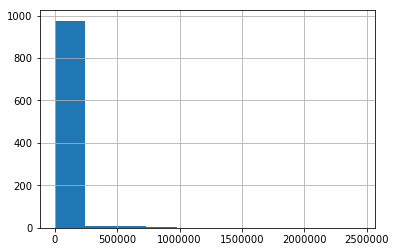

In [44]:
df_out.phi.hist()

Here is a major problem with "rejection sampling" in high dimensions: you have to run the model many many many many many times to find even a few realizations that fit the data acceptably well.  With all these parameters, there are so many possible combinations, that very few realizations fit the data very well...we will address this problem later, so for now, let bump our "good enough" threshold to some realizations to plot:

In [47]:
acceptable_phi = 1300.0
good_enough = df_out.loc[df_out.phi<acceptable_phi].index.values
print(good_enough)

[  2  23  27  45  87 103 108 134 158 161 165 221 289 298 332 342 352 373
 385 398 400 435 444 464 468 476 502 506 524 529 533 585 594 610 695 731
 733 760 764 775 798 885 922 933 953 967 982]


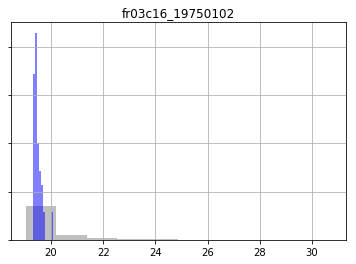

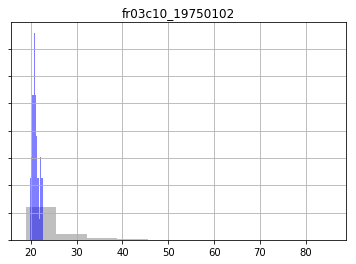

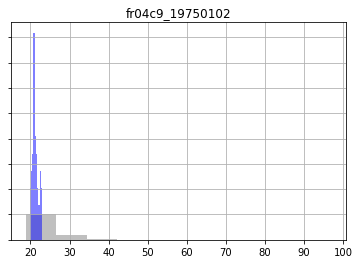

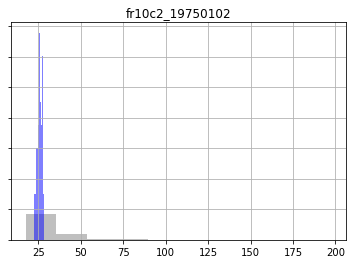

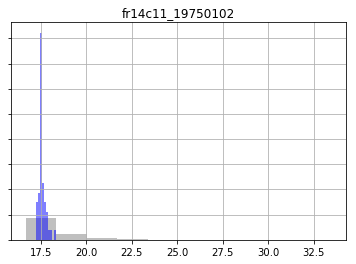

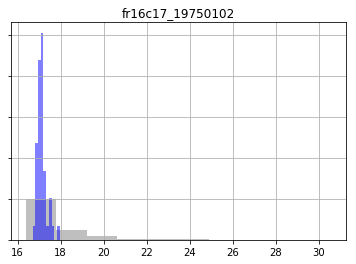

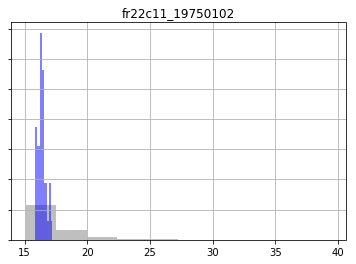

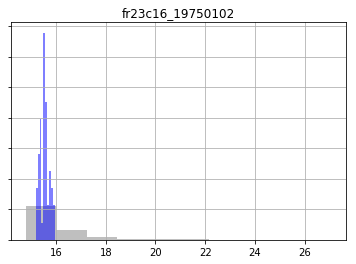

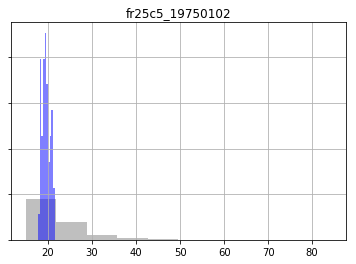

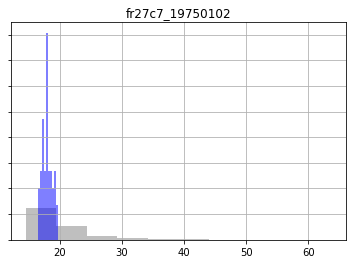

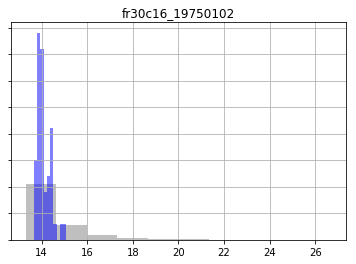

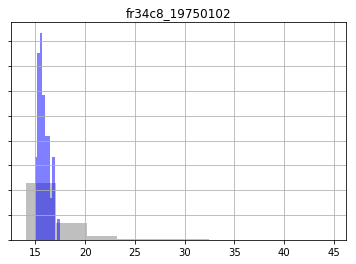

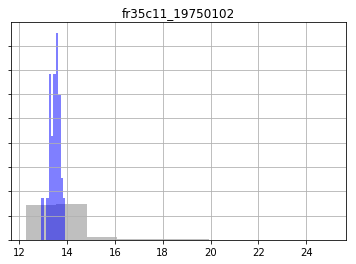

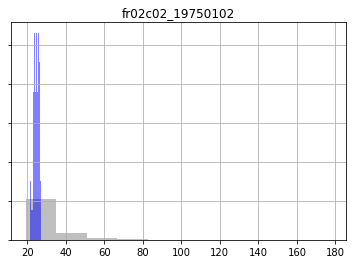

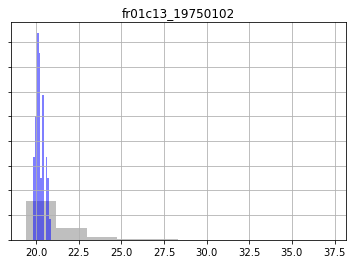

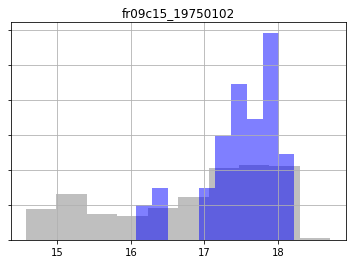

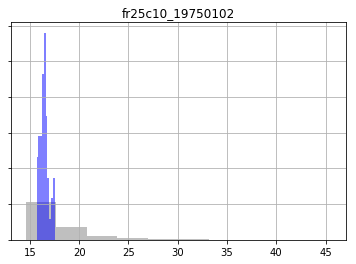

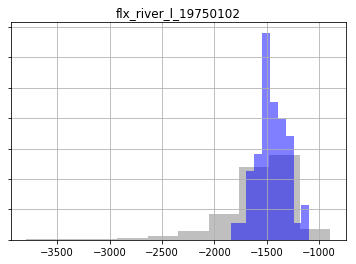

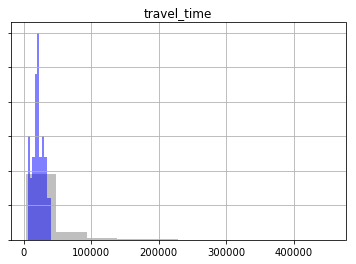

In [48]:
for forecast in mc.pst.forecast_names:
    ax = df_out.loc[:,forecast].hist(alpha=0.5,color='0.5',normed=True)
    ax.set_yticklabels([])
    df_out.loc[good_enough,forecast].hist(ax=ax,alpha=0.5,color='b',normed=True)
    ax.set_title(forecast)   
    plt.show()
    

Interesting results!!! We see that for the river flux and travel time forecasts, the posterior uncertainty is very similar to the prior...that means "calibration" hasn't helped us learn about these forecasts...

As before, let's now use our knowledge of the "truth" to see how we are doing...

In [ ]:
for forecast in mc.pst.forecast_names:
    ax = df_out.loc[:,forecast].hist(alpha=0.5,color='0.5',normed=True)
    ax.set_yticklabels([])
    df_out.loc[good_enough,forecast].hist(ax=ax,alpha=0.5,color='b',normed=True)
    ax.set_title(forecast)   
    ylim = ax.get_ylim()
    v = mc.pst.observation_data.loc[forecast,"obsval"]
    ax.plot([v,v],ylim,"k--",lw=2.0)
    ax.set_title(forecast)
    plt.show()

Oh no!  We are STILL not bracketing the truth for several forecasts...